# 7章 畳み込みニューラルネットワーク

In [4]:
import sys, os
sys.path.append(os.pardir)
sys.path.append(f"{os.pardir}/deep-learning-from-scratch")

import numpy as np
import pickle
from beartype import beartype
from collections import OrderedDict
from nptyping import *
from typing import Any
from common.layers import SoftmaxWithLoss
from common.util import im2col,col2im

In [5]:
x = np.random.rand(10,1,28,28)
x.shape
# (10, 1, 28, 28) ミニバッチ, チャンネル, 高さ, 幅

(10, 1, 28, 28)

In [6]:
x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)   # (9, 75) フィルターの適用領域の数(=1*(((7-5)/1)+1)**2), 入力特徴マップの要素数

(9, 75)


In [7]:
print(x1[0][0])
print(col1[0])

[[0.29071762 0.36059174 0.06859933 0.72546234 0.05395164 0.80230681
  0.19251097]
 [0.17624593 0.04464497 0.58770625 0.23806146 0.78852219 0.46851595
  0.17487459]
 [0.77161536 0.85546382 0.70683669 0.94498593 0.29982821 0.41599263
  0.24431456]
 [0.62169088 0.62845354 0.82541094 0.86526018 0.23798586 0.50953767
  0.49000122]
 [0.44169407 0.56941924 0.0515174  0.64070452 0.03580293 0.37490072
  0.20375657]
 [0.84952834 0.86074655 0.03138799 0.90464859 0.43669989 0.76119287
  0.83416915]
 [0.86807934 0.54002743 0.39898301 0.14993485 0.68205731 0.70570936
  0.27732789]]
[0.29071762 0.36059174 0.06859933 0.72546234 0.05395164 0.17624593
 0.04464497 0.58770625 0.23806146 0.78852219 0.77161536 0.85546382
 0.70683669 0.94498593 0.29982821 0.62169088 0.62845354 0.82541094
 0.86526018 0.23798586 0.44169407 0.56941924 0.0515174  0.64070452
 0.03580293 0.89852111 0.05393244 0.9003714  0.3464487  0.81096756
 0.16638271 0.51134911 0.42585963 0.31034956 0.46406704 0.76090651
 0.908755   0.89015204 

In [8]:
x2 = np.random.rand(10,3,7,7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)   # (90, 75) フィルターの適用領域の数(=10*(((7-5)/1)+1)**2), 入力特徴マップの要素数

(90, 75)


In [9]:
def output_size(x_len, pad, filter_len, stride) -> int:
    rest = ((x_len + 2 * pad) - filter_len)
    if rest < 0:
        raise Exception(f"Filter length {filter_len} is longer than input size {x_len} + {pad}!")
    elif rest % stride != 0:
        raise Exception(f"Rest length {rest} and stride {stride} are conflicted!")
    else:
        return int(rest / stride + 1)  # reshapeにも使うのでintにする

class Convolution:
    # 今回はフィルターのチャンネル数を3で固定している
    @beartype
    def __init__(self, W: NDArray[Shape['FN,C,FH,FW'],Float], b: NDArray[Shape['FN'], Float], stride=1, pad=0):
        # FN: Filter Number
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    @beartype
    def forward(self, x: NDArray[Shape['N,C,H,W'],Any]):
        # Float32が送られてくる。コード全体を通してFloat64の場合もあり使い分けがよく分からないので、いったん型は指定しない。
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = output_size(H, self.pad, FH, self.stride)
        out_w = output_size(W, self.pad, FW, self.stride)

        col: NDArray[Shape['N*Out_h*Out_w,C*FH*FW'], Float] = im2col(x, FH, FW, self.stride, self.pad)
        col_W: NDArray[Shape['C*FH*FW,FN'], Float] = self.W.reshape(FN, -1).T
        out: NDArray[Shape['N*Out_h*Out_w,FN', Float]] = np.dot(col, col_W) + self.b
        reshaped_out: NDArray[Shape['N,FN,Out_h,Out_w'], Float] = out.reshape(N, out_h, out_w, FN).transpose(0,3,1,2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return reshaped_out

    @beartype
    def backward(self, dout: NDArray[Shape['N,FN,Out_h,Out_w'], Float]):
        FN, C, FH, FW = self.W.shape
        dout_matrix: NDArray[Shape['N*Out_h*Out_w,FN'], Float] = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db: NDArray[Shape['1,N'], Float] = np.sum(dout_matrix, axis=0)
        dW_matrix: NDArray[Shape['C*FH*FW,FN'], Float] = np.dot(self.col.T, dout_matrix)
        self.dW: NDArray[Shape['FN,C,FH,FW']] = dW_matrix.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol: NDArray[Shape['N*Out_h*Out_w,C*FH*FN'], Float] = np.dot(dout_matrix, self.col_W.T)
        dx: NDArray[Shape['N,C,H,W']] = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


In [10]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        # pool_h, pool_wはそれぞれプーリング適用領域の高さ・幅。例えば3x3=9からmaxを取るなら、pool_h=3, pool_w=3
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max: NDArray[Shape['N*Out_h*Out_w*C,1'], Int] = None

    @beartype
    def forward(self, x: NDArray[Shape['N,C,H,W'], Float]):
        # 出力特徴マップの奥行きを、対象が色ではないのにチャンネルと呼ぶのは個人的にまだ違和感があるが、そのうち慣れる。
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col: NDArray[Shape['N*Out_h*Out_w,C*Pool_h*Pool_w'], Float] = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # im2colはフィルタ適用領域向けに実装されている。フィルタはチャンネルをまたいで適用されるが、プーリングはチャンネルごとに適用される。
        # そのため、colをチャンネルごとに改行することで、プーリング適用領域ごとに別々の行にする。
        reshaped_col: NDArray[Shape['N*Out_h*Out_w*C,Pool_h*Pool_w'], Float] = col.reshape(-1, self.pool_h*self.pool_w)
        arg_max = np.argmax(reshaped_col, axis=1)
        out: NDArray[Shape['N*C,1'], Float] = np.max(reshaped_col, axis=1)
        reshaped_out: NDArray[Shape['N,C,Out_h,Out_w'], Float] = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)

        self.x = x
        self.arg_max = arg_max

        return reshaped_out

    @beartype
    def backward(self, dout: NDArray[Shape['N,C,Out_h,Out_w'], Float]):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [11]:
# Rectifyは電流の交流を整流にすることから名付けられた。電流の交流は正負の電流が交互に流れるが、整流にすると正の電流のみが流れる。
class Relu:
    def __init__(self):
        self.mask = None

    @beartype
    def forward(self, x:NDArray):
        # NDArray[Shape['N,FN,Out_h,Out_w'], Any]|NDArray[Shape['N,Hidden_size'], Any] で定義したい。isinstance()では判定できるが、beartypeでは失敗するため諦めた。
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    @beartype
    def backward(self, dout: NDArray):
        dout[self.mask] = 0
        dx = dout

        return dx


In [12]:
class Affine:
    def __init__(self, W: NDArray[Shape['S,WS'], Float], b: NDArray[Shape['D'], Float]):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    @beartype
    def forward(self, x: NDArray):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(x, self.W) + self.b

        return out

    @beartype
    def backward(self, dout: NDArray[Shape['N,WS'], Float]):
        dx: NDArray[Shape['N,S'], Float] = np.dot(dout, self.W.T)
        self.dW: NDArray[Shape['S,WS'], Float] = np.dot(self.x.T, dout)
        self.db: NDArray[Shape['1'], Float] = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

In [13]:
# 畳み込み層 → 全結合層(ReLU) → 全結合層(Softmax)を想定

class SimpleConvNet:
    @beartype
    def __init__(self, input_dim=(1,28,28),
        # filter_size:5は、5x5を表す。正方形がメジャー。
        conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
        hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = int(1 + (input_size + 2*filter_pad - filter_size) / filter_stride)
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        self.params = {}
        self.params['W1']: NDArray[Shape['FN,C,FS,FS'],Float] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2']: NDArray[Shape['PS,HS']] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3']: NDArray[Shape['HS,OS']] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    @beartype
    def predict(self, x: NDArray):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    @beartype
    def loss(self, x: NDArray, t: NDArray[Shape['N'], Int]):
        y = self.predict(x)
        return self.last_layer.forward(y,t)

    @beartype
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    @beartype
    def gradient(self, x: NDArray, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)


train loss:2.3001801661352212
=== epoch:1, train acc:0.208, test acc:0.219 ===
train loss:2.296732256845275
train loss:2.2928850492122224
train loss:2.290013603671233
train loss:2.284018685787875
train loss:2.2707778013264743
train loss:2.260144170903759
train loss:2.2449025683850894
train loss:2.223492559175965
train loss:2.187705469838722
train loss:2.1671641642128137
train loss:2.1392639641352504
train loss:2.0610642966090644
train loss:2.034386152134264
train loss:2.02723391317461
train loss:1.9110515422262497
train loss:1.7957259080845922
train loss:1.8092916186091321
train loss:1.7956966959703615
train loss:1.634565735427775
train loss:1.599107354104922
train loss:1.5922319818868857
train loss:1.4360950824206582
train loss:1.3493298290039875
train loss:1.2339569841455118
train loss:1.1549720346594576
train loss:1.1398969648280586
train loss:1.0766146622790418
train loss:0.9884613959903747
train loss:0.9816034325955588
train loss:0.8698234518245633
train loss:0.8482119284631314
tr

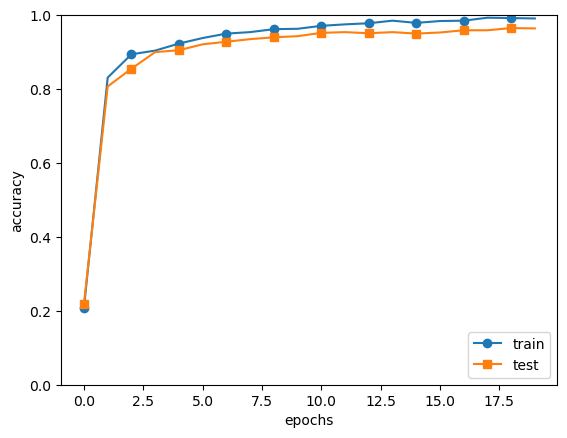

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()